# Simulation of data

In [1037]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.formula.api as smf

from datetime import date, timedelta
import random

colors = plt.cycler(color=["#557A95",   "#957055", "#559570"]) 
sns.set_context('paper', font_scale=1.4)
plt.rcParams['figure.figsize'] = [9,6]
plt.rcParams['savefig.dpi'] = 300
plt.rc("legend", frameon=False)
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['axes.prop_cycle'] = colors
mycolors = colors.by_key()["color"]

## Make fake data

In [1038]:
def rnd_dates(start_dts:datetime.date, 
              end_dts:datetime.date, 
              size=100):
    
    random_date = [start_dts + timedelta(days=random.randrange((end_dts - start_dts).days)) 
                   for _ in range(n)]
    return random_date

In [1049]:
np.random.seed(102323)
n = 500 

In [1050]:
# Simulate customers which churned
np.random.seed(102323)
age = np.random.choice(range(18,60), size=n)
payment = np.random.choice(["paypal","credit card","manual transfer"], p=[0.4,0.3,0.3], size=n)
area = np.random.choice([1,2,3],p=[0.1,0.3,0.6],size=n)
dates = rnd_dates(date(2019,1,1),date(2019,7,31), size=n)
X_churned = np.c_[age, payment, area, dates]
a = 0.845
y_churned = np.random.choice([0,1], p=[1-a,a], size=n)

In [1051]:
# Simulate customers which did not churn
np.random.seed(102323)
age = np.random.choice(range(30,81),size=n)
payment = np.random.choice(["paypal","credit card","manual transfer"], p=[0.1,0.2,0.7], size=n)
area = np.random.choice([1,2,3],p=[0.6,0.3,0.1],size=n)
dates = rnd_dates(date(2019,3,1),date(2019,12,31), size=n)
X_notchurned = np.c_[age, payment, area, dates]
a = 0.173
y_notchurned = np.random.choice([0,1], p=[1-a,a], size=n)

In [1052]:
# Data not informative for modell
np.random.seed(102323)
gender = np.random.choice(["male","female"], size=n*2)
tenor = np.round(stats.lognorm(1.6).rvs(n*2),0)
bill = np.round(stats.lognorm(1.1).rvs(n*2) * 25,2)

In [1053]:
X = np.vstack((X_churned, X_notchurned))
y = np.hstack((y_churned, y_notchurned))#
X.shape, y.shape

((1000, 4), (1000,))

In [1054]:
df = pd.DataFrame(np.c_[y,X], columns=["churn","age", "type_payment","region", "contract_date"])
df["gender"] = gender 
df["tenor"] = tenor
df["bill"] = bill

In [1055]:
df = df.sample(frac=1).reset_index(drop=True)

In [1056]:
int_cols = ["churn","age", "region"]
df[num_cols] = df[num_cols].astype(int)
df[["tenor","bill"]] = df[["tenor","bill"]].astype(float)
df[["contract_date"]] = df[["contract_date"]].apply(pd.to_datetime)

In [1057]:
df.head()

,churn,age,type_payment,region,contract_date,gender,tenor,bill
0,0,47,paypal,1,2019-09-03,male,0.0,21.0
1,1,32,manual transfer,2,2019-06-03,female,0.0,31.0
2,1,42,manual transfer,2,2019-02-23,male,0.0,21.0
3,0,38,manual transfer,1,2019-07-05,male,2.0,49.0
4,1,43,credit card,3,2019-04-27,male,1.0,55.0


In [1121]:
df.to_csv("Churn.csv",index=False)

## Build simple models for testing

In [1058]:
df["month"] = df["contract_date"].dt.month

In [1123]:
full = "churn ~ age + type_payment + C(region) + gender + tenor + bill + month"
part = "churn ~ age"
model = smf.logit(part,data=df).fit()

Optimization terminated successfully.
         Current function value: 0.628140
         Iterations 5


In [1124]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.09376
Time:                        09:41:40   Log-Likelihood:                -628.14
converged:                       True   LL-Null:                       -693.13
Covariance Type:            nonrobust   LLR p-value:                 4.144e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2662      0.222     10.188      0.000       1.830       2.702
age           -0.0484      0.005    -10.598      0.000      -0.057      -0.039
==============================================================================
"""

In [1125]:
np.exp(-0.0284)/(1+np.exp(-0.0284))

0.4929004771761796

In [1126]:
model.pred_table()

array([[297., 200.],
       [187., 316.]])

In [1130]:
all_accs = []
cs = np.linspace(0.30,0.55,num=1000)
for c in cs:
    yhat = np.where(1/(1+np.exp(-model.fittedvalues)) >c,1,0)
    acc = accuracy_score(yhat,df["churn"])
    all_accs.append(acc)

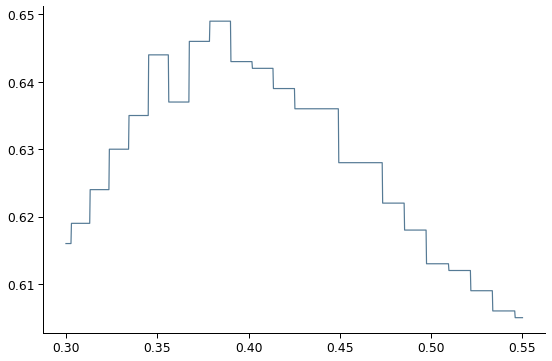

In [1131]:
plt.plot(cs,all_accs)

In [1132]:
df.churn

0      0
1      1
2      1
3      0
4      1
      ..
995    0
996    0
997    0
998    1
999    1
Name: churn, Length: 1000, dtype: int64

In [1133]:
churn = df["churn"] + stats.norm(0,1).rvs(n*2) * 0.05

Text(0.5, 1.0, 'Churn vs. age\n(spreaded to show categories)')

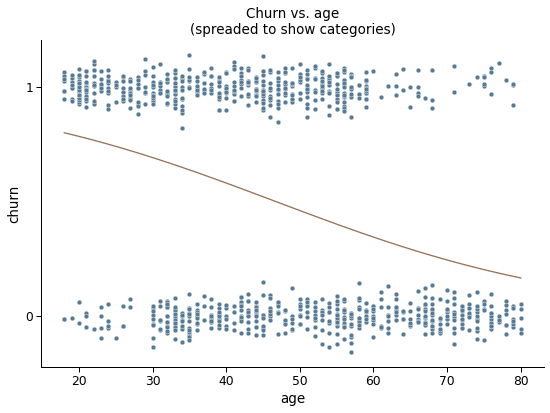

In [1134]:
col = "age"
sns.scatterplot(x=df[col],y=churn,estimator=False)
probs = 1/(1+np.exp(-model.fittedvalues))
sns.lineplot(x=df[col],y=probs, color=mycolors[1])
plt.yticks([0,1])
plt.title("Churn vs. age\n(spreaded to show categories)")

<AxesSubplot:xlabel='age', ylabel='churn'>

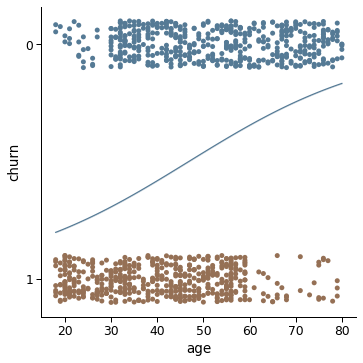

In [1137]:
sns.catplot(x="age",y="churn", data=df,orient="h", )
sns.lineplot(y=probs, x=df["age"])

In [1138]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score

In [1139]:
df = df[["churn","age","region","tenor","bill","month"]]

In [1140]:
clf = DecisionTreeClassifier()
X, y = df.drop(labels="churn", axis=1), df["churn"]

In [1141]:
clf.fit(X,y)

DecisionTreeClassifier()

In [1142]:
yhat = clf.predict(X)

In [1143]:
confusion_matrix(df["churn"],yhat)

array([[497,   0],
       [  0, 503]])